In [ ]:
#hide
%load_ext autoreload
%autoreload 2

# statsforecast

> Forecasting using statistical models

[![CI](https://github.com/Nixtla/statsforecast/actions/workflows/ci.yaml/badge.svg?branch=main)](https://github.com/Nixtla/statsforecast/actions/workflows/ci.yaml)
[![Python](https://img.shields.io/pypi/pyversions/statsforecast)](https://pypi.org/project/statsforecast/)
[![PyPi](https://img.shields.io/pypi/v/statsforecast?color=blue)](https://pypi.org/project/statsforecast/)
[![License](https://img.shields.io/github/license/Nixtla/statsforecast)](https://github.com/Nixtla/statsforecast/blob/main/LICENSE)

## Motivation

Statistical models are widely used to forecast time series in production and as a benchmark, including the `auto_arima` model. However, python alternatives tend to be slow and inaaccurate, preventing data scientists from quickly iterating and deploying these models in production for a large number of time series. `StatsForecast` includes a large battery of models that can efficiently fit thousands of time series. In particular, `StatsForecast` includes the `auto_arima` model based on the R implementation (developed by Rob Hyndman) and optimized using `numba`.

### Accuracy comparison

To test the accuracy of our implementation, we performed experiments with different datasets and models. We took `Daily`, `Hourly` and `Weekly` data from the M4 competition. From python, we selected `pmdarima` to compare `auto_arima` implementations and also `prophet`, one of the most widely used forecasting libraries in the world. In addition, we compared our model against the original R implementation. The following table summaries the results. As can be seen, our `auto_arima` is the best model in accuracy (measured by the `MASE` loss) and time, even compared with the original implementation. 

| dataset   | metric   |   auto_arima_nixtla | auto_arima_pmdarima [1] |   auto_arima_r |   prophet |
|:----------|:---------|--------------------:|----------------------:|---------------:|----------:|
| M4-Daily     | MASE     |                **3.26** |                  3.35 |           4.46 |     14.26 |
| M4-Daily     | time     |                **1.41** |                 27.61 |           1.81 |    514.33 |
| M4-Hourly    | MASE     |                **0.92** |                ---    |           1.02 |      1.78 |
| M4-Hourly    | time     |               **12.92** |                ---    |          23.95 |     17.27 |
| M4-Weekly    | MASE     |                **2.34** |                  2.47 |           2.58 |      7.29 |
| M4-Weekly    | time     |                0.42 |                  2.92 |           **0.22** |     19.82 |


[1] The model `auto_arima` from `pmdarima` had several problems with Hourly data. An issue was opened.

### Computational efficiency comparison

Data scientists and developers have to iterate their models quickly in order to select the best approach and, once selected, they need a fast solution to deploy it into production so that business decisions can be made in a reasonable amount of time. Therefore, we compared our implementation in computational time based on the number of time series. The following graph shows the results. As we can see, the best model is our `auto_arima`. According to the table above, the computational performance does not compromise the accuracy.

![](../examples/computational-efficiency.png)

You can reproduce the results [here](../experiments/arima/).

## Install
`pip install statsforecast`

## How to use

In [ ]:
import numpy as np
import pandas as pd
from IPython.display import display, Markdown

import matplotlib.pyplot as plt
from statsforecast import StatsForecast
from statsforecast.models import seasonal_naive, auto_arima
from statsforecast.utils import AirPassengers

In [ ]:
horizon = 12
ap_train = AirPassengers[:-horizon]
ap_test = AirPassengers[-horizon:]

In [ ]:
series_train = pd.DataFrame(
    {
        'ds': np.arange(1, ap_train.size + 1),
        'y': ap_train
    },
    index=pd.Index([0] * ap_train.size, name='unique_id')
)

In [ ]:
def display_df(df):
    display(Markdown(df.to_markdown()))

In [ ]:
fcst = StatsForecast(
    series_train, 
    models=[(auto_arima, 12), (seasonal_naive, 12)], 
    freq='M', 
    n_jobs=1
)
forecasts = fcst.forecast(12)
display_df(forecasts)

2022-02-18 00:33:15 statsforecast.core INFO: Computing forecasts
2022-02-18 00:33:23 statsforecast.core INFO: Computed forecasts for auto_arima_season_length-12.
2022-02-18 00:33:24 statsforecast.core INFO: Computed forecasts for seasonal_naive_season_length-12.


|   unique_id |   ds |   auto_arima_season_length-12 |   seasonal_naive_season_length-12 |
|------------:|-----:|------------------------------:|----------------------------------:|
|           0 |  133 |                       424.16  |                               360 |
|           0 |  134 |                       407.082 |                               342 |
|           0 |  135 |                       470.861 |                               406 |
|           0 |  136 |                       460.914 |                               396 |
|           0 |  137 |                       484.901 |                               420 |
|           0 |  138 |                       536.904 |                               472 |
|           0 |  139 |                       612.903 |                               548 |
|           0 |  140 |                       623.903 |                               559 |
|           0 |  141 |                       527.903 |                               463 |
|           0 |  142 |                       471.903 |                               407 |
|           0 |  143 |                       426.903 |                               362 |
|           0 |  144 |                       469.903 |                               405 |

In [ ]:
forecasts['y_test'] = ap_test

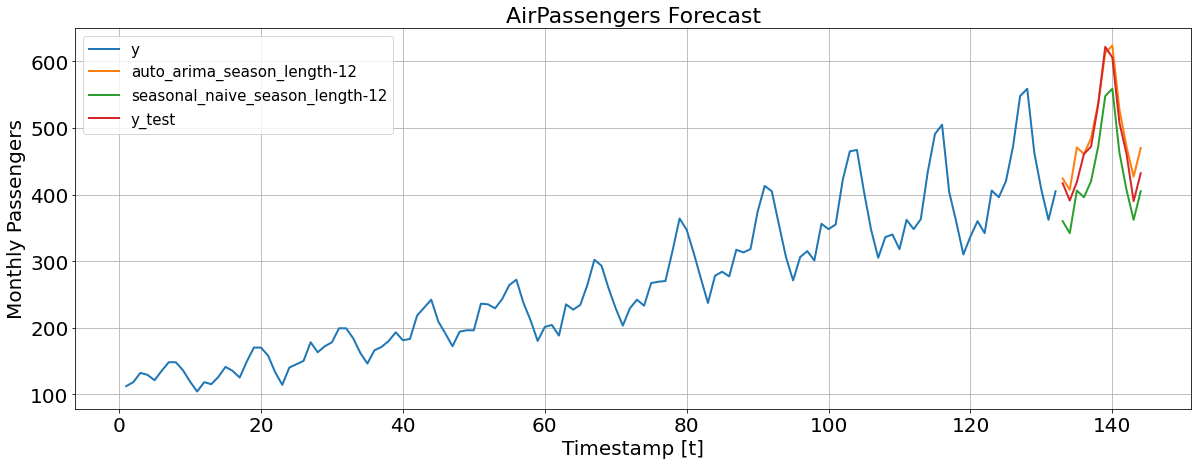

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (20, 7))
pd.concat([series_train, forecasts]).set_index('ds').plot(ax=ax, linewidth=2)
ax.set_title('AirPassengers Forecast', fontsize=22)
ax.set_ylabel('Monthly Passengers', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(20)